In [63]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

%matplotlib inline

In [143]:
df = pd.read_csv('cleanWithVenues.csv', index_col="Unnamed: 0")
df.head()

,Neighborhood Name,Area,Average Household Size,Female Population,Male Population,Median Age Among Men,Median Age Among Women,Median Income,Median Rent,Percentage of Family Households,Percentage of Married Families,Percentage of Married Families with Children,Percentage of Never-Married Men,Percentage of Never-Married Women,Percentage of People Who Speak English Poorly or Not at All,Percentage of Single Mother Families,Population,Population Density,Residents Born Foreign,Residents Born as U.S. Citizens Outside the U.S.,Residents Born in Texas,Residents Born in the U.S.,Address,Coordinates,Latitude,Longitude,Park,Mexican Restaurant,Convenience Store,Sandwich Place,Discount Store,Playground,Video Store,Fast Food Restaurant,Gym,Pool,Hotel,Music Venue,Grocery Store,Mobile Phone Shop,Arcade,Bar,American Restaurant,BBQ Joint,Ice Cream Shop,Chinese Restaurant,Art Gallery,Dog Run,Pharmacy,Gas Station,Business Service,Food Truck,Burger Joint,Construction & Landscaping,Food & Drink Shop,Athletics & Sports,Coffee Shop,Pizza Place,Shipping Store,Pawn Shop,Steakhouse,Flea Market,Fried Chicken Joint,Jewelry Store,Gym / Fitness Center,Restaurant,Golf Course,Pet Store,Café,Furniture / Home Store,Lake,Camera Store,Dive Bar,Casino,Thrift / Vintage Store,Pub
0,Alamo Heights,0.503,1.6,232,242,33.3,31.1,80729.0,1516.0,17.9,18.9,29.6,23.4,23.0,0.0,35.1,475,945.0,20.0,2.2,48.1,29.7,"Alamo Heights, Fort Worth, TX","(None, None)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arlington Heights,2.031,4.8,5589,4815,39.8,35.7,86764.0,887.0,38.6,38.3,38.7,16.8,18.8,0.8,12.0,10405,5124.0,4.6,1.3,65.3,28.9,"Arlington Heights, Fort Worth, TX","(32.7265197, -97.3919628)",32.726520,-97.391963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arlington Heights Sector,11.136,3.1,17089,15559,38.4,37.4,69104.0,849.0,35.2,32.9,32.7,17.9,19.1,2.7,21.0,32648,2932.0,9.6,1.6,64.5,24.4,"Arlington Heights Sector, Fort Worth, TX","(None, None)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Belmont Terrace,0.202,7.5,320,379,28.5,30.7,38563.0,578.0,60.1,45.7,17.4,24.7,16.5,28.7,45.5,699,3461.0,35.8,1.6,54.3,8.3,"Belmont Terrace, Fort Worth, TX","(32.7811685, -97.36639)",32.781168,-97.366390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Benbrook,12.514,3.9,11443,11050,40.1,44.7,63316.0,841.0,48.9,54.2,31.4,13.3,9.9,2.3,9.3,22494,1797.0,4.7,1.7,63.9,29.7,"Benbrook, Fort Worth, TX","(32.7129739, -97.4445299)",32.712974,-97.444530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Creating functions to clean and normalize data

In [144]:
def setToZero(item):
    if type(item) == float:
        return 0
    return item
    

def killNAN(df, cols):
    for col in cols:
        df[col] = df[col].apply(setToZero)

killNAN(df, df.columns[-50:])
df.head()

,Neighborhood Name,Area,Average Household Size,Female Population,Male Population,Median Age Among Men,Median Age Among Women,Median Income,Median Rent,Percentage of Family Households,Percentage of Married Families,Percentage of Married Families with Children,Percentage of Never-Married Men,Percentage of Never-Married Women,Percentage of People Who Speak English Poorly or Not at All,Percentage of Single Mother Families,Population,Population Density,Residents Born Foreign,Residents Born as U.S. Citizens Outside the U.S.,Residents Born in Texas,Residents Born in the U.S.,Address,Coordinates,Latitude,Longitude,Park,Mexican Restaurant,Convenience Store,Sandwich Place,Discount Store,Playground,Video Store,Fast Food Restaurant,Gym,Pool,Hotel,Music Venue,Grocery Store,Mobile Phone Shop,Arcade,Bar,American Restaurant,BBQ Joint,Ice Cream Shop,Chinese Restaurant,Art Gallery,Dog Run,Pharmacy,Gas Station,Business Service,Food Truck,Burger Joint,Construction & Landscaping,Food & Drink Shop,Athletics & Sports,Coffee Shop,Pizza Place,Shipping Store,Pawn Shop,Steakhouse,Flea Market,Fried Chicken Joint,Jewelry Store,Gym / Fitness Center,Restaurant,Golf Course,Pet Store,Café,Furniture / Home Store,Lake,Camera Store,Dive Bar,Casino,Thrift / Vintage Store,Pub
0,Alamo Heights,0.503,1.6,232,242,33.3,31.1,80729.0,1516.0,17.9,18.9,29.6,23.4,23.0,0.0,35.1,475,945.0,20.0,2.2,48.1,29.7,"Alamo Heights, Fort Worth, TX","(None, None)",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Arlington Heights,2.031,4.8,5589,4815,39.8,35.7,86764.0,887.0,38.6,38.3,38.7,16.8,18.8,0.8,12.0,10405,5124.0,4.6,1.3,65.3,28.9,"Arlington Heights, Fort Worth, TX","(32.7265197, -97.3919628)",32.726520,-97.391963,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Arlington Heights Sector,11.136,3.1,17089,15559,38.4,37.4,69104.0,849.0,35.2,32.9,32.7,17.9,19.1,2.7,21.0,32648,2932.0,9.6,1.6,64.5,24.4,"Arlington Heights Sector, Fort Worth, TX","(None, None)",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Belmont Terrace,0.202,7.5,320,379,28.5,30.7,38563.0,578.0,60.1,45.7,17.4,24.7,16.5,28.7,45.5,699,3461.0,35.8,1.6,54.3,8.3,"Belmont Terrace, Fort Worth, TX","(32.7811685, -97.36639)",32.781168,-97.366390,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Benbrook,12.514,3.9,11443,11050,40.1,44.7,63316.0,841.0,48.9,54.2,31.4,13.3,9.9,2.3,9.3,22494,1797.0,4.7,1.7,63.9,29.7,"Benbrook, Fort Worth, TX","(32.7129739, -97.4445299)",32.712974,-97.444530,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Clustering to find wealthier and poorer geographic areas

In [191]:
pd.set_option('display.max_columns', None)

cols = ['Average Household Size', 'Median Income', 'Median Rent', 'Population Density', 'Latitude', 'Longitude']
df_wealth = df[cols].copy()
df_wealth = df_wealth.dropna()
df_wealth.head(), df_wealth.shape

(   Average Household Size  Median Income  Median Rent  Population Density  \
 1                     4.8        86764.0        887.0              5124.0   
 3                     7.5        38563.0        578.0              3461.0   
 4                     3.9        63316.0        841.0              1797.0   
 5                     2.4        59511.0        592.0               875.0   
 6                     2.5        71314.0        800.0              1006.0   
 
     Latitude  Longitude  
 1  32.726520 -97.391963  
 3  32.781168 -97.366390  
 4  32.712974 -97.444530  
 5  32.712974 -97.444530  
 6  32.765323 -97.162629  , (107, 6))

In [192]:
cols = ['Average Household Size', 'Median Income', 'Median Rent', 'Population Density']
df_noCoords = df_wealth[cols].copy()
df_noCoords.head()

,Average Household Size,Median Income,Median Rent,Population Density
1,4.8,86764.0,887.0,5124.0
3,7.5,38563.0,578.0,3461.0
4,3.9,63316.0,841.0,1797.0
5,2.4,59511.0,592.0,875.0
6,2.5,71314.0,800.0,1006.0


In [193]:
data = StandardScaler().fit_transform(df_noCoords)

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

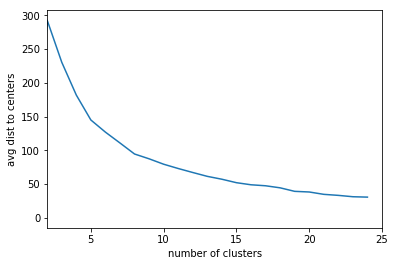

In [194]:
max_n_clusters = 25
squared_distance = np.zeros(max_n_clusters)
for k in range(2,max_n_clusters):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(data)
    squared_distance[k] = kmeans.inertia_
    print(k,sep=' ', end=' ', flush=True)
    
plt.figure()
plt.plot(squared_distance)
plt.xlim((2,max_n_clusters))
plt.xlabel('number of clusters')
plt.ylabel('avg dist to centers')
plt.show()

In [195]:
kmeans = KMeans(n_clusters = 8, random_state = 0).fit(data)
df_wealth['cluster'] = kmeans.labels_
df_wealth.head()

,Average Household Size,Median Income,Median Rent,Population Density,Latitude,Longitude,cluster
1,4.8,86764.0,887.0,5124.0,32.726520,-97.391963,5
3,7.5,38563.0,578.0,3461.0,32.781168,-97.366390,1
4,3.9,63316.0,841.0,1797.0,32.712974,-97.444530,0
5,2.4,59511.0,592.0,875.0,32.712974,-97.444530,0
6,2.5,71314.0,800.0,1006.0,32.765323,-97.162629,0


In [196]:
df_wealth.groupby('cluster').mean().sort_values(by='Median Income')

,Average Household Size,Median Income,Median Rent,Population Density,Latitude,Longitude
cluster,,,,,,
4,38.000000,11838.000000,204.000000,2287.000000,32.707479,-97.379122
3,3.433333,33271.333333,603.666667,13841.666667,32.719949,-97.345246
1,5.160000,35519.100000,584.066667,4025.800000,32.737142,-97.323915
7,15.800000,39711.200000,636.600000,5081.400000,32.745486,-97.401428
6,4.275000,47571.375000,715.562500,6253.500000,32.748249,-97.319152
0,3.722222,57125.074074,782.814815,2254.851852,32.672248,-97.242890
2,2.755556,85270.333333,1290.666667,2657.000000,32.546380,-97.078347
5,5.975000,85294.500000,937.437500,4006.437500,32.573724,-97.212963


In [200]:
cluster_descs = [
    "Lowest population density; above average income and rent.",
    "Second lowest rent. Well below average income.",
    "Very high income. By far the highest rent.",
    "Highest population density. Moderately low rent. Second lowest income.",
    "Lowest income by far. So much so that the data may been recorded improperly.",
    "Highest income. Moderately high rent. Large average household size.",
    "Largely average. Above average population density, though",
    "Large household size. Midling to low income and rent."
]

In [201]:
colors = [
    'red',
    'blue',
    'green',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'gray',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]

map_clusters = folium.Map(location=[32.7555, -97.3308], zoom_start=11)

for neigh in df_wealth.to_dict('records'):
    label_text = "cluster: %d, %s"%(neigh['cluster'], cluster_descs[int(neigh['cluster'])])
    label = folium.Popup(label_text, parse_html=True)
    
    cm = folium.Marker(
        [neigh['Latitude'],neigh['Longitude']],
        popup = label,
        icon=folium.Icon(color=colors[int(neigh['cluster'])]),
    )
    cm.add_to(map_clusters)
    
    legend_html = '''
     <div style="position: fixed; bottom: 50px; left: 50px; width: 100px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;">
     &nbsp; Cluster 0 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:red"></i><br>
     &nbsp; Cluster 1 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:blue"></i><br>
     &nbsp; Cluster 2 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:green"></i><br>
     &nbsp; Cluster 3 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:darkred"></i><br>
     &nbsp; Cluster 4 &nbsp; <i class="fa fa-map-marker fa-2x:" style='color:lightred"></i></br>
     &nbsp; Cluster 5 &nbsp; <i class="fa fa-map-marker fa-2x:" style='color:orange"></i></br>
     &nbsp; Cluster 6 &nbsp; <i class="fa fa-map-marker fa-2x:" style='color:beige"></i></br>
     &nbsp; Cluster 7 &nbsp; <i class="fa fa-map-marker fa-2x:" style='color:darkblue"></i></br>
    </div>
     '''
map_clusters.get_root().html.add_child(folium.Element(legend_html))
    
map_clusters

The area of the city that is southwest of downtown seems to be comprised of high income, high rent areas. Cluster 5 neghborhoods, which appear to represent high-income, family-friendly neighborhoods, appear throughout the western side of the city, but do not appear on the east. Cluster two neighborhoods, which have the highest rent are, in general, nowhere near downtown. Low income/rent clusters appear in every part of the city, but they're more focused on the east side of the city, making that appear to be a lower rent area.

# Clustering based on family type and median age.

In [228]:
cols = ['Average Household Size', 'Median Age Among Men', 'Median Age Among Women', 'Median Income', 
        'Percentage of Married Families with Children', 'Percentage of Family Households', 'Percentage of Never-Married Men', 
        'Percentage of Never-Married Women', 'Percentage of Single Mother Families', 'Latitude', 'Longitude']

df_family = df[cols].copy()
df_family = df_family.dropna()
df_family.head(), df_family.shape

(   Average Household Size  Median Age Among Men  Median Age Among Women  \
 1                     4.8                  39.8                    35.7   
 3                     7.5                  28.5                    30.7   
 4                     3.9                  40.1                    44.7   
 5                     2.4                  42.3                    46.6   
 6                     2.5                  32.7                    36.8   
 
    Median Income  Percentage of Married Families with Children  \
 1        86764.0                                          38.7   
 3        38563.0                                          17.4   
 4        63316.0                                          31.4   
 5        59511.0                                          39.6   
 6        71314.0                                          18.7   
 
    Percentage of Family Households  Percentage of Never-Married Men  \
 1                             38.6                             16

In [229]:
cols = cols[:-2]

df_noCoords = df_family[cols].copy()
df_noCoords.head()

,Average Household Size,Median Age Among Men,Median Age Among Women,Median Income,Percentage of Married Families with Children,Percentage of Family Households,Percentage of Never-Married Men,Percentage of Never-Married Women,Percentage of Single Mother Families
1,4.8,39.8,35.7,86764.0,38.7,38.6,16.8,18.8,12.0
3,7.5,28.5,30.7,38563.0,17.4,60.1,24.7,16.5,45.5
4,3.9,40.1,44.7,63316.0,31.4,48.9,13.3,9.9,9.3
5,2.4,42.3,46.6,59511.0,39.6,38.7,7.2,5.8,49.3
6,2.5,32.7,36.8,71314.0,18.7,46.9,17.7,24.4,22.5


In [230]:
data = StandardScaler().fit_transform(df_noCoords)

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

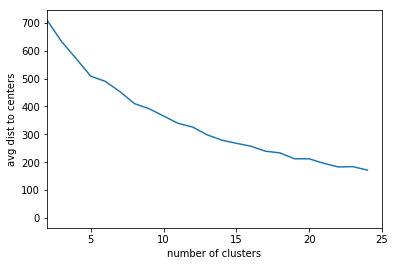

In [231]:
max_n_clusters = 25
squared_distance = np.zeros(max_n_clusters)
for k in range(2,max_n_clusters):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(data)
    squared_distance[k] = kmeans.inertia_
    print(k,sep=' ', end=' ', flush=True)
    
plt.figure()
plt.plot(squared_distance)
plt.xlim((2,max_n_clusters))
plt.xlabel('number of clusters')
plt.ylabel('avg dist to centers')
plt.show()

In [232]:
kmeans = KMeans(n_clusters = 9, random_state = 0).fit(data)
df_family['cluster'] = kmeans.labels_
df_family.head()

,Average Household Size,Median Age Among Men,Median Age Among Women,Median Income,Percentage of Married Families with Children,Percentage of Family Households,Percentage of Never-Married Men,Percentage of Never-Married Women,Percentage of Single Mother Families,Latitude,Longitude,cluster
1,4.8,39.8,35.7,86764.0,38.7,38.6,16.8,18.8,12.0,32.726520,-97.391963,1
3,7.5,28.5,30.7,38563.0,17.4,60.1,24.7,16.5,45.5,32.781168,-97.366390,8
4,3.9,40.1,44.7,63316.0,31.4,48.9,13.3,9.9,9.3,32.712974,-97.444530,1
5,2.4,42.3,46.6,59511.0,39.6,38.7,7.2,5.8,49.3,32.712974,-97.444530,1
6,2.5,32.7,36.8,71314.0,18.7,46.9,17.7,24.4,22.5,32.765323,-97.162629,8


In [233]:
df_family.groupby('cluster').mean().sort_values(by='Average Household Size')

,Average Household Size,Median Age Among Men,Median Age Among Women,Median Income,Percentage of Married Families with Children,Percentage of Family Households,Percentage of Never-Married Men,Percentage of Never-Married Women,Percentage of Single Mother Families,Latitude,Longitude
cluster,,,,,,,,,,,
2,2.100000,38.000000,37.100000,66818.000000,33.300000,23.300000,18.100000,29.800000,81.900000,32.653170,-97.410582
1,3.811538,40.565385,41.369231,78453.384615,33.242308,43.900000,14.069231,13.457692,14.100000,32.642557,-97.283619
8,4.566667,31.185714,35.223810,41429.380952,17.638095,46.457143,19.928571,22.495238,20.457143,32.641632,-97.169839
6,4.584615,36.853846,42.800000,48104.769231,20.415385,47.753846,18.053846,14.907692,19.207692,32.723124,-97.311518
7,4.733333,29.988889,33.411111,54304.666667,23.344444,62.144444,13.222222,15.522222,8.444444,32.483439,-97.074521
3,5.400000,44.400000,46.300000,80391.000000,86.600000,29.800000,23.500000,15.600000,33.600000,32.701103,-97.398685
0,5.932258,30.145161,30.461290,41688.903226,18.154839,61.041935,21.512903,16.480645,9.541935,32.769232,-97.342517
4,7.933333,33.733333,33.600000,102443.000000,31.833333,40.300000,26.200000,31.133333,5.400000,32.753881,-97.354553
5,29.500000,36.700000,32.600000,20321.000000,5.400000,61.250000,20.750000,26.500000,16.700000,32.767125,-97.382182


In [234]:
cluster_descs = [
    'High percentage of family households. Low percentage of married families with children.',
    'Small average household size. Low percentage of never-married individuals. High median income.',
    'Lowest average household size. Lowest percentage of family households.',
    
    'Extremely high percentage of family households. Highest median age. High median income.',
    'Very large average household size. Highest median income.',
    'Outrageously high average household size and outrageously low median income.',
    
    'Low percentage of never-married individuals. Otherwise very average.',
    'High percentage of family households. Low median age.',
    'Low percentage of married families with children.Otherwise fairly average.'
]

In [235]:
colors = [
    'red',
    'blue',
    'green',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'gray',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]

map_clusters = folium.Map(location=[32.7555, -97.3308], zoom_start=11)

for neigh in df_family.to_dict('records'):
    label_text = "cluster: %d, %s"%(neigh['cluster'], cluster_descs[int(neigh['cluster'])])
    label = folium.Popup(label_text, parse_html=True)
    
    cm = folium.Marker(
        [neigh['Latitude'],neigh['Longitude']],
        popup = label,
        icon=folium.Icon(color=colors[int(neigh['cluster'])]),
    )
    cm.add_to(map_clusters)
    
    legend_html = '''
     <div style="position: fixed; bottom: 50px; left: 50px; width: 100px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;">
     &nbsp; Cluster 0 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:red"></i><br>
     &nbsp; Cluster 1 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:blue"></i><br>
     &nbsp; Cluster 2 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:green"></i><br>
     &nbsp; Cluster 3 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:darkred"></i><br>
     &nbsp; Cluster 4 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:lightred"></i></br>
     &nbsp; Cluster 5 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:orange"></i></br>
     &nbsp; Cluster 6 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:beige"></i></br>
     &nbsp; Cluster 7 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:darkblue"></i></br>
     &nbsp; Cluster 8 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:lightblue"></i></br>
    </div>
     '''
map_clusters.get_root().html.add_child(folium.Element(legend_html))
    
map_clusters

A sizable portion of neighborhoods fall into cluster 0, which appears to be the cluster most aligned with working class families. However, cluster 0 neighborhoods seem especially common in the area due north of downtown. The Eastern part of town features many neighborhoods with smaller families and fewer children. The southwest seems to be more suited to married couples with higher shared incomes and small household sizes.

# Clustering based on nation of origin

In [238]:
cols = ['Residents Born Foreign', 'Residents Born as U.S. Citizens Outside the U.S.', 'Residents Born in Texas', 
        'Residents Born in the U.S.', 'Latitude', 'Longitude']

df_origin = df[cols].copy()
df_origin = df_origin.dropna()
df_origin.head(), df_origin.shape

(   Residents Born Foreign  Residents Born as U.S. Citizens Outside the U.S.  \
 1                     4.6                                               1.3   
 3                    35.8                                               1.6   
 4                     4.7                                               1.7   
 5                     5.3                                               1.8   
 6                    14.2                                               1.8   
 
    Residents Born in Texas  Residents Born in the U.S.   Latitude  Longitude  
 1                     65.3                        28.9  32.726520 -97.391963  
 3                     54.3                         8.3  32.781168 -97.366390  
 4                     63.9                        29.7  32.712974 -97.444530  
 5                     64.9                        28.0  32.712974 -97.444530  
 6                     54.6                        29.5  32.765323 -97.162629  ,
 (107, 6))

In [239]:
cols = cols[:-2]

df_noCoords = df_origin[cols].copy()
df_noCoords.head()

,Residents Born Foreign,Residents Born as U.S. Citizens Outside the U.S.,Residents Born in Texas,Residents Born in the U.S.
1,4.6,1.3,65.3,28.9
3,35.8,1.6,54.3,8.3
4,4.7,1.7,63.9,29.7
5,5.3,1.8,64.9,28.0
6,14.2,1.8,54.6,29.5


In [240]:
data = StandardScaler().fit_transform(df_noCoords)

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

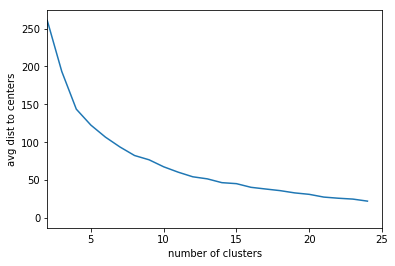

In [241]:
max_n_clusters = 25
squared_distance = np.zeros(max_n_clusters)
for k in range(2,max_n_clusters):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(data)
    squared_distance[k] = kmeans.inertia_
    print(k,sep=' ', end=' ', flush=True)
    
plt.figure()
plt.plot(squared_distance)
plt.xlim((2,max_n_clusters))
plt.xlabel('number of clusters')
plt.ylabel('avg dist to centers')
plt.show()

In [243]:
kmeans = KMeans(n_clusters = 8, random_state = 0).fit(data)
df_origin['cluster'] = kmeans.labels_
df_origin.head()

,Residents Born Foreign,Residents Born as U.S. Citizens Outside the U.S.,Residents Born in Texas,Residents Born in the U.S.,Latitude,Longitude,cluster
1,4.6,1.3,65.3,28.9,32.726520,-97.391963,2
3,35.8,1.6,54.3,8.3,32.781168,-97.366390,4
4,4.7,1.7,63.9,29.7,32.712974,-97.444530,2
5,5.3,1.8,64.9,28.0,32.712974,-97.444530,2
6,14.2,1.8,54.6,29.5,32.765323,-97.162629,0


In [246]:
df_origin.groupby('cluster').mean().sort_values(by='Residents Born in Texas')

,Residents Born Foreign,Residents Born as U.S. Citizens Outside the U.S.,Residents Born in Texas,Residents Born in the U.S.,Latitude,Longitude
cluster,,,,,,
0,12.100000,1.466667,53.586667,32.840000,32.484680,-96.985656
4,36.000000,0.993750,54.993750,8.087500,32.776420,-97.342311
5,7.775000,2.887500,57.900000,31.462500,32.786699,-97.353859
3,22.966667,1.325000,58.833333,16.883333,32.758537,-97.327132
2,7.054545,1.481818,63.000000,28.481818,32.704691,-97.354557
6,12.081250,0.762500,63.343750,23.831250,32.599919,-97.196240
1,23.342857,0.914286,66.678571,9.121429,32.701651,-97.349294
7,12.225000,1.275000,77.125000,9.900000,32.728675,-97.266992


In [248]:
cluster_descs = [
    'Highest proportion of Non-Texan US born individuals. Lowest proportion of native Texans.',
    'High proportion of both native Texan and immigrant populations.',
    'Lowest proportion of residents born as non US citizens.',
    'Overall, very average',
    'Most residents born as non US citizens.',
    'High proportion of non-Texan US born citizens. Low immigrant population',
    'Overall, very average.',
    'Very high proportion of native Texans'
]

In [249]:
colors = [
    'red',
    'blue',
    'green',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'gray',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]

map_clusters = folium.Map(location=[32.7555, -97.3308], zoom_start=11)

for neigh in df_origin.to_dict('records'):
    label_text = "cluster: %d, %s"%(neigh['cluster'], cluster_descs[int(neigh['cluster'])])
    label = folium.Popup(label_text, parse_html=True)
    
    cm = folium.Marker(
        [neigh['Latitude'],neigh['Longitude']],
        popup = label,
        icon=folium.Icon(color=colors[int(neigh['cluster'])]),
    )
    cm.add_to(map_clusters)
    
    legend_html = '''
     <div style="position: fixed; bottom: 50px; left: 50px; width: 100px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;">
     &nbsp; Cluster 0 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:red"></i><br>
     &nbsp; Cluster 1 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:blue"></i><br>
     &nbsp; Cluster 2 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:green"></i><br>
     &nbsp; Cluster 3 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:darkred"></i><br>
     &nbsp; Cluster 4 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:lightred"></i></br>
     &nbsp; Cluster 5 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:orange"></i></br>
     &nbsp; Cluster 6 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:beige"></i></br>
     &nbsp; Cluster 7 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:darkblue"></i></br>
    </div>
     '''
map_clusters.get_root().html.add_child(folium.Element(legend_html))
    
map_clusters

There are a noticably high proportion of immigrant-rich neighborhoods in the northern part of the city, while the southeast is dominated by a combination of both native Texans and immigrants. The Southwest, meanwhile, has a comparitively very low immigrant population.